# Sentiment Analysis Using Bag-of-Words

- Sentiment analysis is to analyze the textual documents and extract information that is related to the author's sentiment or opinion. It is sometimes referred to as **opinion mining**.
- It is popular and widely used in industry, e.g., corporate surveys, feedback surveys, social media data, reviews for movies, places, hotels, commodities, etc..
- The sentiment information from texts can be crucial to further **decision making** in the industry.

- Output of Sentiment Analysis
    - Qualitative: overall sentiment scale (positive/negative)
    - Quantitative: sentiment polarity scores 

- I am using a movie review system as an example.
- And the classification task is simple: to classify the document into one of the two classes, i.e., positive or negative.
- Most importantly, we will be using mainly the module `sklearn` for creating and training the classifier.

In [1]:
import nltk, random
from nltk.corpus import movie_reviews
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Loading

- We will use the corpus `nlkt.corpus.movie_reviews` as our data.
- Please download the corpus if you haven't.

In [7]:
# Importing ALL nltk - a lot on the HD (3.2GB).
#import nltk
#nltk.download('all')

In [8]:

print(len(movie_reviews.fileids()))
print(movie_reviews.categories())
print(movie_reviews.words()[:100])
print(movie_reviews.fileids()[:10])

2000
['neg', 'pos']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]
['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt']


- Rearrange the corpus data as a list of tuple, where the first element is the word tokens of the documents, and the second element is the label of the documents (i.e., sentiment labels).

In [15]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.seed(123)
random.shuffle(documents)

- Important descriptive statistics:
    - Corpus Size (Number of Documents)
    - Corpus Size (Number of Words)
    - Distribution of the Two Classes
- It is important to always report the above necessary descriptive statistics when presenting your classifiers.

In [16]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Corpus Size (words): {}'.format(np.sum([len(d) for (d,l) in documents])))
print('Sample Text of Doc 1:')
print('-'*30)
print(' '.join(documents[0][0][:50])) # first 50 words of the first document:

Number of Reviews/Documents: 2000
Corpus Size (words): 1583820
Sample Text of Doc 1:
------------------------------
most movies seem to release a third movie just so it can be called a trilogy . rocky iii seems to kind of fit in that category , but manages to be slightly unique . the rocky formula of " rocky loses fight / rocky trains / rocky wins fight


In [17]:
# Check Sentiment Distribution of the Current Dataset.
from collections import Counter
sentiment_distr = Counter([label for (words, label) in documents])
print(sentiment_distr)

Counter({'pos': 1000, 'neg': 1000})


## Train-Test Split

- We split the entire dataset into two parts: training set and testing set.
- The proportion of training and testing sets may depend on the corpus size.
- In the train-test split, make sure the the distribution of the classes is proportional.

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(documents, test_size = 0.31, random_state=42)

In [19]:
# Sentiment Distrubtion for Train and Test.
print(Counter([label for (words, label) in train]))
print(Counter([label for (words, label) in test]))

Counter({'pos': 690, 'neg': 690})
Counter({'pos': 310, 'neg': 310})


- Because in most of the ML steps, the feature sets and the labels are often separated as two units, we split our training data into `X_train` and `y_train` as the **features** (X) and **labels** (y) in training.
- Likewise, we split our testing data into `X_test` and `y_test` as the **features** (X) and **labels** (y) in testing.

In [20]:
X_train = [' '.join(words) for (words, label) in train]
X_test = [' '.join(words) for (words, label) in test]
y_train = [label for (words, label) in train]
y_test = [label for (words, label) in test]

## Text Vectorization

- In feature-based machine learning, we need to vectorize texts into feature sets (i.e., feature engineering on texts).
- We use the naive bag-of-words text vectorization. In particular, we use the weighted version of BOW.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df = 10, token_pattern = r'[a-zA-Z]+')
X_train_bow = tfidf_vec.fit_transform(X_train) # fit train.
X_test_bow = tfidf_vec.transform(X_test) # transform test.

- Important Notes:
    - Always split the data into train and test first **before** vectorizing the texts
    - Otherwise, you would leak information to the training process, which may lead to over-fitting
    - When vectorizing the texts, `fit_transform()` on the **training** set and `transform()` on the **testing** set.
    - Always report the number of features used in the model.

In [22]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(1380, 6261)
(620, 6261)


## Model Selection and Cross Validation

- For our current binary sentiment classifier, we will try a few common classification algorithms:
    - Support Vector Machine
    - Decision Tree
    - Naive Bayes
    - Logistic Regression
    

- The common steps include:
    - We fit the model with our training data.
    - We check the model stability, using **k-fold cross validation** on the training data.
    - We use the fitted model to make prediction.
    - We evaluate the model prediction by comparing the predicted classes and the true labels.

### SVM

In [23]:
from sklearn import svm

model_svm = svm.SVC(C=8.0, kernel='linear')
model_svm.fit(X_train_bow, y_train)

SVC(C=8.0, kernel='linear')

In [24]:
from sklearn.model_selection import cross_val_score
model_svm_acc = cross_val_score(estimator=model_svm, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_svm_acc

array([0.82608696, 0.81884058, 0.85507246, 0.82971014, 0.85144928])

In [25]:
model_svm.predict(X_test_bow[:10])
#print(model_svm.score(test_text_bow, test_label))

array(['pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'pos'], dtype='<U3')

### Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

model_dec = DecisionTreeClassifier(max_depth=10, random_state=0)
model_dec.fit(X_train_bow, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [28]:
model_dec_acc = cross_val_score(estimator=model_dec, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_dec_acc

array([0.63043478, 0.62318841, 0.70289855, 0.62681159, 0.67391304])

In [29]:
model_dec.predict(X_test_bow[:10])

array(['pos', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'neg',
       'neg'], dtype='<U3')

### Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train_bow.toarray(), y_train)

GaussianNB()

In [32]:
model_gnb_acc = cross_val_score(estimator=model_gnb, X=X_train_bow.toarray(), y=y_train, cv=5, n_jobs=-1)
model_gnb_acc

array([0.72826087, 0.69202899, 0.75362319, 0.67028986, 0.71376812])

In [33]:
model_gnb.predict(X_test_bow[:10].toarray())

array(['pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg'], dtype='<U3')

### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

model_lg = LogisticRegression()
model_lg.fit(X_train_bow, y_train)

LogisticRegression()

In [35]:
model_lg_acc = cross_val_score(estimator=model_lg, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_lg_acc

array([0.8115942 , 0.79347826, 0.81884058, 0.77898551, 0.83333333])

In [36]:
model_lg.predict(X_test_bow[:10].toarray())

array(['pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg',
       'pos'], dtype='<U3')

## Evaluation

- To evaluate each model's performance, there are several common metrics in use:
    - Precision
    - Recall
    - F-score
    - Accuracy
    - Confusion Matrix

In [37]:
#Mean Accuracy.
print(model_svm.score(X_test_bow, y_test))
print(model_dec.score(X_test_bow, y_test))
print(model_gnb.score(X_test_bow.toarray(), y_test))
print(model_lg.score(X_test_bow, y_test))

0.817741935483871
0.6693548387096774
0.7048387096774194
0.8016129032258065


In [40]:
# F1.
from sklearn.metrics import f1_score

y_pred = model_svm.predict(X_test_bown)
#y_pred = model_svm.predict(X_test_brown)

f1_score(y_test, y_pred, 
         average=None, 
         labels = movie_reviews.categories())

NameError: name 'X_test_bown' is not defined

/home/pa-on-vajert/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


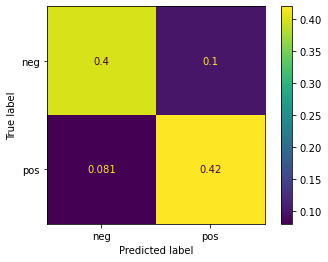

In [42]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(model_svm, X_test_bow, y_test, normalize='all')

/home/pa-on-vajert/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


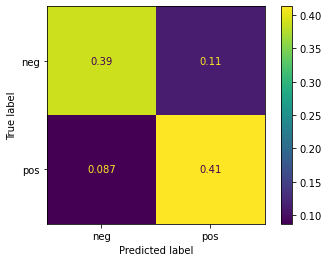

In [43]:
plot_confusion_matrix(model_lg, X_test_bow.toarray(), y_test, normalize='all')

In [44]:
# try a whole new self-created review.
new_review =['This book looks soso like the content but the cover is weird',
             'This book looks soso like the content and the cover is weird'
            ]
new_review_bow = tfidf_vec.transform(new_review)
model_svm.predict(new_review_bow)

array(['neg', 'neg'], dtype='<U3')

## Tuning Model Hyperparameters - Grid Search

- For each model, we have not optimized it in terms of its hyperparameter setting.
- Now that SVM seems to perform the best among all, we take this as our base model and further fine-tune its hyperparameter using **cross-validation** and **Grid Search**.

In [45]:
%%time

from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=10, n_jobs=-1) ## `-1` run in parallel
clf.fit(X_train_bow, y_train)

CPU times: user 5.39 s, sys: 0 ns, total: 5.39 s
Wall time: 1min 21s


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

- We can check the parameters that yield the most optimal results in the Grid Search:

In [46]:
#print(sorted(clf.cv_results_.keys()))
print(clf.best_params_)

{'C': 4, 'kernel': 'rbf'}


In [47]:
print(clf.score(X_test_bow, y_test))

0.8209677419354838


## Post-hoc Analysis

- After we find the optimal classifier, next comes the most important step: interpret the classifier.
- A good classifier may not always perform as we have expected. Chances are that the classifier may have used cues that are unexpected for decision making.
- In the post-hoc analysis, we are interested in:
    - Which features contribute to the classifier's prediction the most?
    - Which features are more relevant to each class prediction?

- We will introduce three methods for post-hoc analysis:
    - LIME
    - Model coefficients and feature importance
    - Permutation importances

### LIME

- Using LIME (Local Interpretable Model-agnostic Explanations) to interpret the **importance of the features** in relation to the model prediction.
- LIME was introduced in 2016 by Marco Ribeiro and his collaborators in a paper called [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938) 
- Its objective is to explain a model prediction for a specific text sample in a human-interpretable way.

- What we have done so far tells us that the model accuracy is good, but **we have no idea whether the classifier has learned features that are useful and meaningful**.
- How can we identify important words that may have great contribution to the model prediction?

In [53]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:004.8 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=86ebf1ce24eb7706ff206e6ead612bdfe2f4c6b46add6556b9717245cfdceedb
  Stored in directory: /home/pa-on-vajert/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import Pipeline

In [55]:
# Refit model based on optimal parameter settings.
pipeline = Pipeline([
  ('vectorizer',tfidf_vec), 
  ('clf', svm.SVC(C=1, kernel='linear', probability=True))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=10, token_pattern='[a-zA-Z]+')),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

In [56]:
import textwrap
reviews_test = X_test
sentiments_test = y_test



# We choose a sample from test set
idx = 210
text_sample = reviews_test[idx]
class_names = ['negative', 'positive']

print('Review ID-{}:'.format(idx))
print('-'*50)
print('Review Text:\n', textwrap.fill(text_sample,400))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('Probability(negative) =', pipeline.predict_proba([text_sample])[0,0])
print('Predicted class: %s' % pipeline.predict([text_sample]))
print('True class: %s' % sentiments_test[idx])

Review ID-210:
--------------------------------------------------
Review Text:
 in ` enemy at the gates ' , jude law is a gifted russian sniper made hero by a political officer named danilov ( joseph fiennes ) who uses him in a propaganda newspaper to raise the hopes of the soldiers and people of stalingrad . it ' s world war ii , and the russian - german standoff in town could determine the outcome of things for the motherland . law ' s vassili is the russian ' s top pawn to
victory . lots of war stuff happens . an older , german version of jude ' s character played by ed harris shows up halfway into the proceedings . he ' s equally talented , and the two men play a cat and mouse game trying to kill each other . they constantly switch roles , as the war fades far into the background . the cast also includes the terrific rachel weisz as a love interest for both vassili
and danilov the set - up is decent , and so are the production values . boasting a wide range of grimy locales , greas

In [57]:
import matplotlib
matplotlib.rcParams['figure.dpi']=300
%matplotlib inline


explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, 
                                         pipeline.predict_proba, 
                                         num_features=20)
explanation.show_in_notebook(text=True)

### Model Coefficients and Feature Importance

- Another way to evaluate the importance of the features is to look at their corresponding coefficients.
    - Positive weights imply positive contribution of the feature to the prediction; negative weights imply negative contribution of the feature to the prediction.
    - The absolute values of the weights indicate the effect sizes of the features.
- Not all ML models provide "coefficients".

In [60]:
# Extract the coefficients of the model from the pipeline.
importances = pipeline.named_steps['clf'].coef_.toarray().flatten()
# Select top 10 positive/negative weights.
top_indices_pos = np.argsort(importances)[::-1][:10] 
top_indices_neg = np.argsort(importances)[:10]
# Get featnames from tfidfvectorizer.
#feature_names = np.array(tfidf_vec.get_feature_names()) # List indexing is different from array.    Future Warning!!!
feature_names = np.array(tfidf_vec.get_feature_names_out()) # List indexing is different from array.

In [61]:
feature_importance_df = pd.DataFrame({'FEATURE': feature_names[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'IMPORTANCE': importances[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'SENTIMENT': ['pos' for _ in range(len(top_indices_pos))]+['neg' for _ in range(len(top_indices_neg))]})
feature_importance_df

,FEATURE,IMPORTANCE,SENTIMENT
0,and,2.630511,pos
1,fun,1.709915,pos
2,great,1.616596,pos
3,rocky,1.507300,pos
4,well,1.499193,pos
5,also,1.443802,pos
6,mulan,1.379427,pos
7,hilarious,1.373260,pos
8,war,1.361547,pos
9,very,1.360978,pos


Text(0.5, 1.0, 'Feature Importance: Top Words')

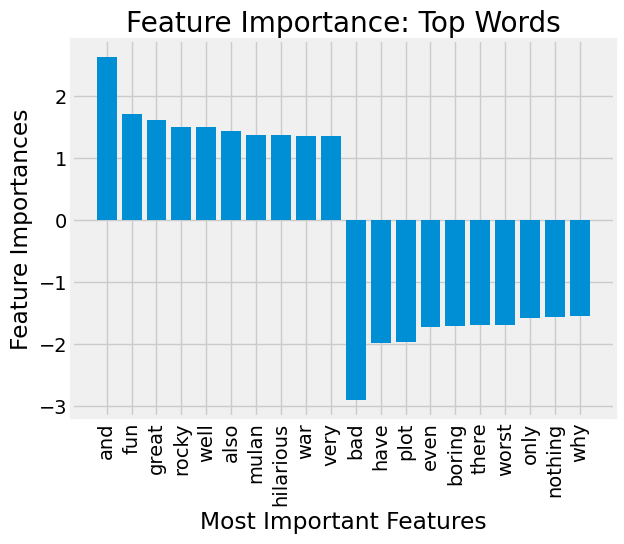

In [62]:
plt.figure(figsize=(7,5), dpi=100)
plt.style.use('fivethirtyeight')
#print(plt.style.available)
plt.bar(x = feature_importance_df['FEATURE'], height=feature_importance_df['IMPORTANCE'])
plt.xlabel("Most Important Features")
plt.ylabel("Feature Importances")
plt.xticks(rotation=90)
plt.title("Feature Importance: Top Words", color="black")

In [76]:
# Why use rpy2?
# Thanks to the rpy2 package, Pythonistas can take advantage of the great work already done by the R community.
# The rpy2 provides an interface that allows you to run R in Python processes. 
# Users can move between languages and use the best of both programming languages.

#pip install rpy2

In [78]:
#    %load_ext rpy2.ipython

In [79]:
%%R -i feature_importance_df -w 6 -h 6 --units in -r 150
library(ggplot2)
library(dplyr)

head(feature_importance_df)

feature_importance_df %>%
    ggplot(aes(reorder(FEATURE,IMPORTANCE), IMPORTANCE, fill=IMPORTANCE, color=SENTIMENT)) +
     geom_bar(stat="identity") +
     coord_flip() +
     scale_fill_gradient2(guide=FALSE) +
     labs(x='FEATURE', x="IMPORTANCE", title="Most Important Features")

UsageError: Cell magic `%%R` not found.


### Permutation Importances

- Permutation feature importance is a model inspection technique that can be applied to any fitted classifier using feature-based ML.
- Permutation importance is defined as the decrease in a model score when a single feature value is randomly shuffled.
    - The drop in the model score is indicative of how much the model depends on the feature.
    - The increase in the model score is indicative of how redundant the feature is.

- Permutation importance reports the importance of the feature as the difference between **target model accuracy** - **shuffled model accuracy**.
    - Positive permutation importance score, Higher importance.
    - Negative permutation importance score, Lower importance.
- See `sklearn` documentation: [4.2 Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

:::{tip}

On which dataset (training, held-out, or testing sets) should be performed the permutation importance computation?

It is suggested to use a held-out set, which makes it possible to highlight which features contribute the most to the generalization power of the classifier (i.e., to avoid overfitting problems).

:::

In [80]:
%%time
from sklearn.inspection import permutation_importance
r = permutation_importance(model_lg, X_test_bow.toarray(), y_test,
                           n_repeats=5,
                           random_state=0, n_jobs=-1)

CPU times: user 19.9 s, sys: 1.74 s, total: 21.6 s
Wall time: 2min 1s


In [41]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

and     0.023 +/- 0.005
bad     0.012 +/- 0.004
is      0.008 +/- 0.004
worst   0.007 +/- 0.002
he      0.005 +/- 0.001
harry   0.005 +/- 0.001
well    0.005 +/- 0.002
will    0.004 +/- 0.001
october 0.004 +/- 0.001
things  0.003 +/- 0.001
unfortunately0.003 +/- 0.001
lame    0.003 +/- 0.001
which   0.003 +/- 0.001
ending  0.003 +/- 0.001
zeta    0.003 +/- 0.000
finds   0.003 +/- 0.000
jackie  0.003 +/- 0.001
violence0.003 +/- 0.001
others  0.003 +/- 0.001
characters0.002 +/- 0.001
problem 0.002 +/- 0.001
death   0.002 +/- 0.001
while   0.002 +/- 0.001
perfect 0.002 +/- 0.001
charlie 0.002 +/- 0.001
hanks   0.002 +/- 0.001
bright  0.002 +/- 0.001
henry   0.002 +/- 0.001
in      0.002 +/- 0.001
contain 0.002 +/- 0.001
everything0.002 +/- 0.001
first   0.002 +/- 0.001
slightly0.002 +/- 0.001
suffers 0.002 +/- 0.001
terribly0.002 +/- 0.001
won     0.002 +/- 0.001
story   0.002 +/- 0.001
except  0.002 +/- 0.001
science 0.002 +/- 0.001
edition 0.002 +/- 0.001
bond    0.002 +/- 0.001
allows 

### Other Variants

- Some of the online code snippets try to implement the `show_most_informative_features()` in `nltk` classifier.
- Here the codes only work with linear classifiers (e.g., Logistic models) in sklearn.
- Need more updates. See this [SO post](https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers)

In [81]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [85]:
#show_most_informative_features(tfidf_vec, model_lg, n=20)
show_most_informative_features(tfidf_vec, model_lg, n=20)

	-2.2238	bad            		2.9642	and            
	-1.4964	to             		1.5511	is             
	-1.3793	have           		1.3907	the            
	-1.3456	t              		1.2873	life           
	-1.3269	worst          		1.2431	as             
	-1.3112	plot           		1.1470	his            
	-1.3018	boring         		1.0719	great          
	-1.2672	there          		1.0689	jackie         
	-1.1435	movie          		1.0658	also           
	-1.1063	no             		1.0623	of             
	-1.0955	nothing        		1.0504	well           
	-1.0673	only           		1.0312	very           
	-1.0433	why            		1.0183	will           
	-1.0310	script         		0.9828	mulan          
	-1.0157	even           		0.9709	family         
	-0.9713	stupid         		0.9200	war            
	-0.9624	supposed       		0.8916	perfect        
	-0.9548	waste          		0.8366	truman         
	-0.9464	be             		0.8164	fun            
	-0.9039	re             		0.8004	rocky          


- For tree-based classifiers, visualization is better.

In [86]:
import sklearn
from sklearn.tree import plot_tree
text_representation = sklearn.tree.export_text(model_dec, feature_names = tfidf_vec.get_feature_names())
print(text_representation)




|--- bad <= 0.02
|   |--- boring <= 0.02
|   |   |--- and <= 0.15
|   |   |   |--- script <= 0.02
|   |   |   |   |--- hilarious <= 0.01
|   |   |   |   |   |--- any <= 0.02
|   |   |   |   |   |   |--- if <= 0.02
|   |   |   |   |   |   |   |--- awful <= 0.02
|   |   |   |   |   |   |   |   |--- it <= 0.01
|   |   |   |   |   |   |   |   |   |--- into <= 0.01
|   |   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |   |   |--- into >  0.01
|   |   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |   |   |--- it >  0.01
|   |   |   |   |   |   |   |   |   |--- better <= 0.04
|   |   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |   |   |--- better >  0.04
|   |   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |   |--- awful >  0.02
|   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |--- if >  0.02
|   |   |   |   |   |   |   |--- so <= 0.02
|   |   |   |   |   

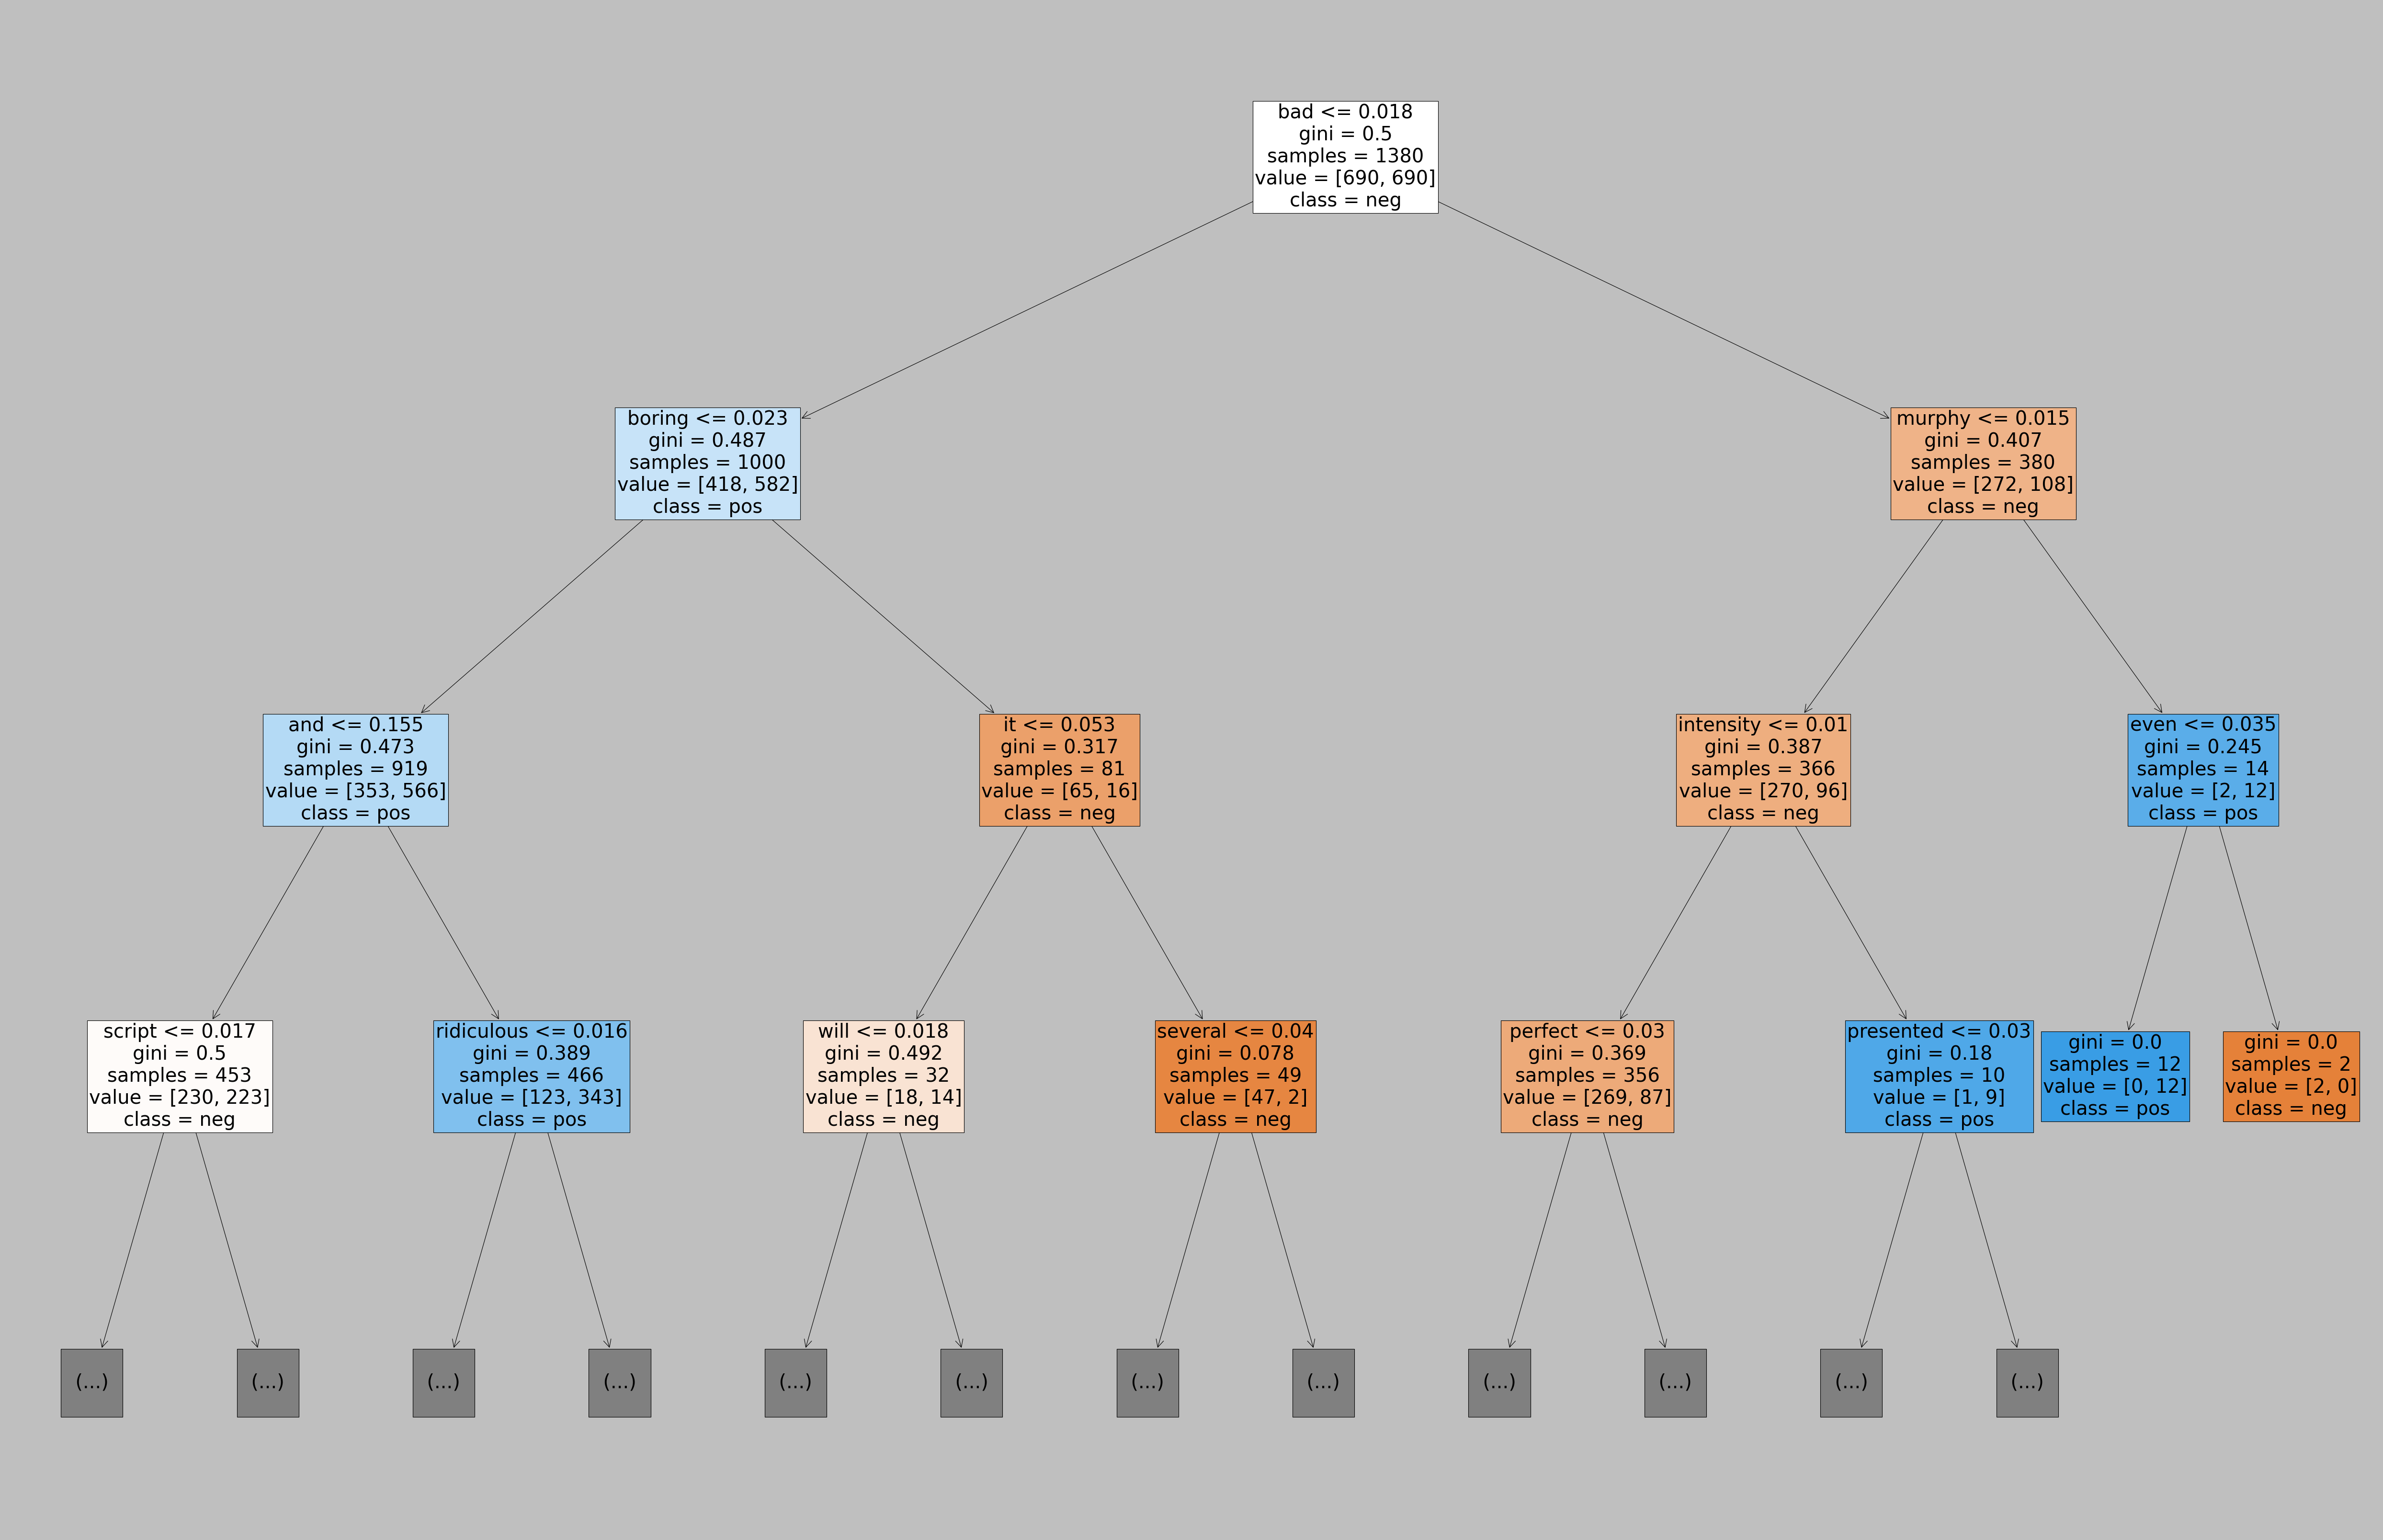

In [88]:
"""
/home/pa-on-vajert/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)

#OLD:
plt.style.use('classic')
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(80,50))
_ = sklearn.tree.plot_tree(model_dec, max_depth=3,
                   feature_names=tfidf_vec.get_feature_names(),  
                   class_names=model_dec.classes_,
                   filled=True, fontsize=36)
"""

# NEW:
plt.style.use('classic')
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(80,50))
_ = sklearn.tree.plot_tree(model_dec, max_depth=3,
                   feature_names=tfidf_vec.get_feature_names_out(),  
                   class_names=model_dec.classes_,
                   filled=True, fontsize=36)

#fig.savefig("decistion_tree.png")

## Saving Model


In [89]:
#  import pickle

# with open('../ml-sent-svm.pkl', 'wb') as f:
#     pickle.dump(clf, f)
# with open('../ml-sent-svm.pkl' 'rb') as f:
#     loaded_svm = pickle.load(f)

## Dictionary-based Sentiment Classifier

- Without machine learning, we can still build a sentiment classifier using a dictionary-based approach.
- Words can be manually annotated with sentiment polarity scores.
- Based on the sentiment dictionary, we can then compute the sentiment scores for a text.

### TextBlob Lexicon

In [97]:
#conda install -c nbsantos textblob

In [99]:
"""
conda install textblob      #for installation.
"""
#import textblob            #to import.
#from textblob import TextBlob


#from textblob import TextBlob

'\nconda install textblob      #for installation.\n'

In [102]:
#doc_sent = TextBlob(X_train[0])
#print(doc_sent.sentiment)
#print(doc_sent.sentiment.polarity)

In [49]:
doc_sents = [TextBlob(doc).sentiment.polarity for doc in X_train]

In [50]:
y_train[:10]

['neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'pos', 'neg', 'pos']

In [51]:
doc_sents_prediction = ['pos' if score >= 0.1 else 'neg' for score in doc_sents]
doc_sents_prediction[:10]

['pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg']

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
print(accuracy_score(y_train, doc_sents_prediction))
print(f1_score(y_train, doc_sents_prediction, average=None, labels=['neg','pos']))

NameError: name 'doc_sents_prediction' is not defined

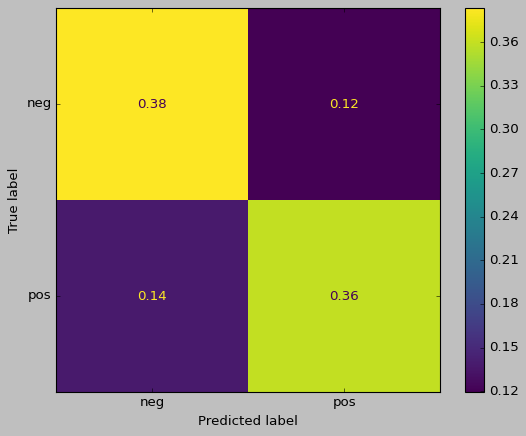

In [53]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_prediction, normalize="all"), display_labels=['neg','pos']).plot()

### AFINN Lexicon

In [54]:
from afinn import Afinn

In [55]:
afn = Afinn(emoticons=True)

afn.score("This movie, not good. worth it :( But can give it a try!! worth it")

0.0

In [56]:
doc_sents_afn = [afn.score(d) for d in X_train]

In [57]:
doc_sents_afn_prediction = ['pos' if score >= 1.0 else 'neg' for score in doc_sents_afn]

In [58]:
print(accuracy_score(y_train, doc_sents_afn_prediction))
print(f1_score(y_train, doc_sents_afn_prediction, average=None, labels=['neg','pos']))

0.6686567164179105
[0.61458333 0.70942408]


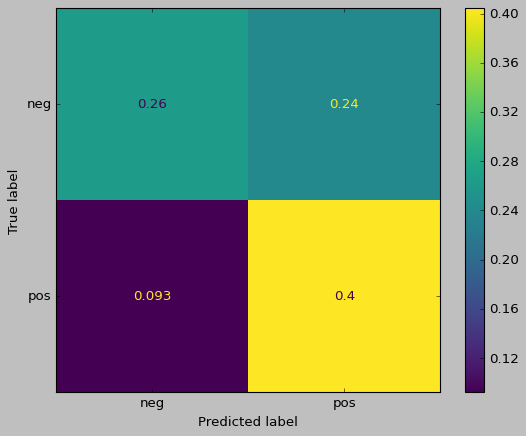

In [59]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_afn_prediction, normalize="all"),display_labels=['neg','pos']).plot()

- Disadvantage of Dictionary-based Approach
    - Constructing the sentiment dictionary is time-consuming.
    - The sentiment dictionary can be topic-dependent.


- English Resources for Sentiment Analysis
    - See Sarkar (2019) Chapter 9 Senitment Analysis (on Unsupervised Lexicon-based Models)
    - [`pattern`](https://github.com/clips/pattern)
    - [`textblob`](https://github.com/sloria/TextBlob)
    - [`affin`](https://github.com/fnielsen/afinn)
- Chinese Resources for Sentiment Analysis
    - [`polyglot`](https://polyglot.readthedocs.io/en/latest/Sentiment.html)
    - [`snownlp`](https://github.com/isnowfy/snownlp) (for simplified Chinese)
    - [ANTUSD (The Augmented NTU Sentiment Dictionary)](http://academiasinicanlplab.github.io/#resources)

## Package Requirement

In [104]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

In [105]:
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scikit-learn==1.0.2
pandas==1.4.1
numpy==1.21.2
nltk==3.7
matplotlib==3.5.1


## References

- Geron (2019), Ch 2 and 3
- Sarkar (2019), Ch 9
- See [Keith Galli's sklearn tutorial](https://github.com/KeithGalli/sklearn)
- See a blog post, [LIME of words: Interpreting RNN Predictions](https://data4thought.com/deep-lime.html).
- See a blog post, [LIME of words: how to interpret your machine learning model predictions](https://data4thought.com/lime-of-words.html)